In [ ]:
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import re
from scipy import linalg
import scipy.ndimage as ndi
# from six.moves import range
import os
import threading

from keras import backend as K


def random_channel_shift(x, intensity, channel_index=0):
    x = np.rollaxis(x, channel_index, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_channel + np.random.uniform(-intensity, intensity), min_x, max_x)
                      for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix


def apply_transform(x, transform_matrix, channel_index=0, fill_mode='nearest', cval=0.):
    x = np.rollaxis(x, channel_index, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                      final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x


def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


def array_to_img(x, dim_ordering='default', scale=True):
    from PIL import Image
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    if dim_ordering == 'th':
        x = x.transpose(1, 2, 0)
    if scale:
        x += max(-np.min(x), 0)
        x /= np.max(x)
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return Image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return Image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise Exception('Unsupported channel number: ', x.shape[2])


def img_to_array(img, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = 'channels_first' if K.image_data_format() == 'th' else 'channels_last'
    if dim_ordering not in ['th', 'tf']:
        raise Exception('Unknown dim_ordering: ', dim_ordering)
    # image has dim_ordering (height, width, channel)
    x = np.asarray(img, dtype='float32')
    if len(x.shape) == 3:
        if dim_ordering == 'th':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if dim_ordering == 'th':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise Exception('Unsupported image shape: ', x.shape)
    return x


class DualImageDataGenerator(object):
    '''Generate minibatches with
    real-time data augmentation.
    Assume X is train img, Y is train label (same size as X with only 0 and 255 for values)
    # Arguments
        featurewise_center: set input mean to 0 over the dataset. Only to X
        samplewise_center: set each sample mean to 0. Only to X
        featurewise_std_normalization: divide inputs by std of the dataset. Only to X
        samplewise_std_normalization: divide each input by its std. Only to X
        zca_whitening: apply ZCA whitening. Only to X
        rotation_range: degrees (0 to 180). To X and Y
        width_shift_range: fraction of total width. To X and Y
        height_shift_range: fraction of total height. To X and Y
        shear_range: shear intensity (shear angle in radians). To X and Y
        zoom_range: amount of zoom. if scalar z, zoom will be randomly picked
            in the range [1-z, 1+z]. A sequence of two can be passed instead
            to select this range. To X and Y
        channel_shift_range: shift range for each channels. Only to X
        fill_mode: points outside the boundaries are filled according to the
            given mode ('constant', 'nearest', 'reflect' or 'wrap'). Default
            is 'nearest'. For Y, always fill with constant 0
        cval: value used for points outside the boundaries when fill_mode is
            'constant'. Default is 0.
        horizontal_flip: whether to randomly flip images horizontally. To X and Y
        vertical_flip: whether to randomly flip images vertically. To X and Y
        rescale: rescaling factor. If None or 0, no rescaling is applied,
            otherwise we multiply the data by the value provided (before applying
            any other transformation). Only to X
        dim_ordering: 'th' or 'tf'. In 'th' mode, the channels dimension
            (the depth) is at index 1, in 'tf' mode it is at index 3.
            It defaults to the `image_dim_ordering` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "th".
    '''
    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 dim_ordering='default'):
        if dim_ordering == 'default':
            dim_ordering = K.image_data_format()
        self.__dict__.update(locals())
        self.mean = None
        self.std = None
        self.principal_components = None
        self.rescale = rescale

        if dim_ordering == 'channels_first':
            self.dim_ordering = dim_ordering = 'th'
        else:
            self.dim_ordering = dim_ordering = 'tf'
        if dim_ordering == 'th':
            self.channel_index = 1
            self.row_index = 2
            self.col_index = 3
        if dim_ordering == 'tf':
            self.channel_index = 3
            self.row_index = 1
            self.col_index = 2

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise Exception('zoom_range should be a float or '
                            'a tuple or list of two floats. '
                            'Received arg: ', zoom_range)

    def flow(self, X, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator(
            X, y, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            dim_ordering=self.dim_ordering,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)

    def standardize(self, x):
        # Only applied to X
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_index = self.channel_index - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_index, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_index, keepdims=True) + 1e-7)

        if self.featurewise_center:
            x -= self.mean
        if self.featurewise_std_normalization:
            x /= (self.std + 1e-7)

        if self.zca_whitening:
            flatx = np.reshape(x, (x.size))
            whitex = np.dot(flatx, self.principal_components)
            x = np.reshape(whitex, (x.shape[0], x.shape[1], x.shape[2]))

        return x

    def random_transform(self, x, y):
        # Need to modify to transform both X and Y ---- to do
        # x is a single image, so it doesn't have image number at index 0
        img_row_index = self.row_index - 1
        img_col_index = self.col_index - 1
        img_channel_index = self.channel_index - 1

        # use composition of homographies to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                    [np.sin(theta), np.cos(theta), 0],
                                    [0, 0, 1]])
        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_index]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_index]
        else:
            ty = 0

        translation_matrix = np.array([[1, 0, tx],
                                       [0, 1, ty],
                                       [0, 0, 1]])
        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0
        shear_matrix = np.array([[1, -np.sin(shear), 0],
                                 [0, np.cos(shear), 0],
                                 [0, 0, 1]])

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)
        zoom_matrix = np.array([[zx, 0, 0],
                                [0, zy, 0],
                                [0, 0, 1]])

        transform_matrix = np.dot(np.dot(np.dot(rotation_matrix, translation_matrix), shear_matrix), zoom_matrix)

        h, w = x.shape[img_row_index], x.shape[img_col_index]
        transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
        x = apply_transform(x, transform_matrix, img_channel_index,
                            fill_mode=self.fill_mode, cval=self.cval)
        # For y, mask data, fill mode constant, cval = 0
        y = apply_transform(y, transform_matrix, img_channel_index,
                            fill_mode="constant", cval=0)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x, self.channel_shift_range, img_channel_index)

        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_index)
                y = flip_axis(y, img_col_index)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_index)
                y = flip_axis(y, img_row_index)

        # TODO:
        # channel-wise normalization
        # barrel/fisheye
        return x, y

    def fit(self, X,
            augment=False,
            rounds=1,
            seed=None):
        '''Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.
        # Arguments
            X: Numpy array, the data to fit on.
            augment: whether to fit on randomly augmented samples
            rounds: if `augment`,
                how many augmentation passes to do over the data
            seed: random seed.
        # Only applied to X
        '''
        X = np.copy(X)
        if augment:
            aX = np.zeros(tuple([rounds * X.shape[0]] + list(X.shape)[1:]))
            for r in range(rounds):
                for i in range(X.shape[0]):
                    aX[i + r * X.shape[0]] = self.random_transform(X[i])
            X = aX

        if self.featurewise_center:
            self.mean = np.mean(X, axis=0)
            X -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(X, axis=0)
            X /= (self.std + 1e-7)

        if self.zca_whitening:
            flatX = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))
            sigma = np.dot(flatX.T, flatX) / flatX.shape[1]
            U, S, V = linalg.svd(sigma)
            self.principal_components = np.dot(np.dot(U, np.diag(1. / np.sqrt(S + 10e-7))), U.T)


class Iterator(object):

    def __init__(self, N, batch_size, shuffle, seed):
        self.N = N
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(N, batch_size, shuffle, seed)

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, N, batch_size=32, shuffle=False, seed=None):
        # ensure self.batch_index is 0
        self.reset()
        while 1:
            if self.batch_index == 0:
                index_array = np.arange(N)
                if shuffle:
                    if seed is not None:
                        np.random.seed(seed + self.total_batches_seen)
                    index_array = np.random.permutation(N)

            current_index = (self.batch_index * batch_size) % N
            if N >= current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = N - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        # ?
        return self.next(*args, **kwargs)


class NumpyArrayIterator(Iterator):

    def __init__(self, X, y, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 dim_ordering='default',
                 save_to_dir=None, save_prefix='', save_format='jpeg'):
        if len(X) != len(y):
            raise Exception('X (images tensor) and y (labels) '
                            'should have the same length. '
                            'Found: X.shape = %s, y.shape = %s' % (np.asarray(X).shape, np.asarray(y).shape))
        if dim_ordering == 'default':
            dim_ordering = K.image_dim_ordering()
        self.X = X
        self.y = y
        self.image_data_generator = image_data_generator
        self.dim_ordering = dim_ordering
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(NumpyArrayIterator, self).__init__(X.shape[0], batch_size, shuffle, seed)

    def next(self):
        # for python 2.x.
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch
        # see http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + list(self.X.shape)[1:]))
        batch_y = np.zeros(tuple([current_batch_size] + list(self.y.shape)[1:]))
        for i, j in enumerate(index_array):
            x = self.X[j]
            label = self.y[j]
            x, label = self.image_data_generator.random_transform(x.astype('float32'), label.astype("float32"))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            batch_y[i] = label
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.dim_ordering, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
                mask = array_to_img(batch_y[i], self.dim_ordering, scale=True)
                fname = '{prefix}_{index}_{hash}_mask.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                mask.save(os.path.join(self.save_to_dir, fname))
        return batch_x, batch_y




In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 8.3 MB/s 


In [ ]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage
import skimage.exposure
import mahotas as mh
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display


In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, \
    Lambda, UpSampling2D, Cropping2D, Concatenate
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [ ]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.8.0
TensorFlow version: 2.8.0


In [ ]:
K.set_image_data_format('channels_first')

In [ ]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""

    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [ ]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [ ]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [ ]:
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(inputs, conv10)

    return model

In [ ]:
model = get_unet_light(img_rows=256, img_cols=256)

model.compile(optimizer=SGD(lr=1e-3, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 256, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 256, 256  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 32, 256, 256  0           ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


# **No need to run**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'all_data.hdf5'), 'r')
h5f = h5py.File('/content/gdrive/MyDrive/RIM_ONE_v3.hdf5', 'r')

Mounted at /content/gdrive


In [ ]:
X = h5f['RIM-ONE v3/256 px/images']
Y = h5f['RIM-ONE v3/256 px/disc']
X[0].shape

(256, 256, 3)

In [ ]:
import cv2

data = np.array(Y[0,:,:,:])
cv2.imwrite('/content/gdrive/MyDrive/weights_folder/test.jpg', data)

True

# New section

In [ ]:
import glob
filelist = glob.glob('/content/gdrive/MyDrive/ORIGA_cropped_v1.0_all/*.jpg')
filelist = sorted(filelist)
HEIGHT = 256
WIDTH = 256
i = 0
imgs = []
for fname in filelist:
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (WIDTH,HEIGHT))
    imgs.append(image)
X = np.array([np.array(i) for i in imgs])

KeyboardInterrupt: ignored

In [ ]:
import scipy.io as sio
import cv2
filelist = glob.glob('/content/gdrive/MyDrive/binarymask/*.mat')
filelist = sorted(filelist)
mat_contents = []
for fname in filelist:
  mat_content = sio.loadmat(fname)
  mask = mat_content['mask']
  mask[mask>0] = 255;
  crop_mask = mask[157:1891, 669:2403]
  img = cv2.resize(crop_mask, (256,256))
  crop_mask = np.expand_dims(img, axis=-1)
  mat_contents.append(crop_mask)

In [ ]:
Y = np.array([np.array(i) for i in mat_contents])
Y.shape

NameError: ignored

In [ ]:
X, Y
Y.shape

In [ ]:
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(n_splits=5).split(X):
    print(_train_idx, _test_idx)
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

In [ ]:
#train_idx = h5f['RIM-ONE v3/train_idx_driu']
#test_idx = h5f['RIM-ONE v3/test_idx_driu']

train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]

In [ ]:
len(X), len(train_idx), len(test_idx)

In [ ]:


train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=50, width_shift_range=0.15, height_shift_range=0.15,
                                   zoom_range=(0.7, 1.3),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()

In [ ]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    batch_y = batch_y / 255.0
    if train_or_test == 'train':
        batch_X, batch_y = next(train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    elif train_or_test == 'test':
        batch_X, batch_y = next(test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, train_or_test='train', batch_size=3, return_orig=False, stationary=False):
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i] for i in idx]
        batch_X = np.array(batch_X).copy()
        batch_y = [y[i] for i in idx]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()

        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)

        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

In [ ]:
gen = data_generator(X, Y, 'train', batch_size=1)
batch = next(gen)
batch[1].shape


In [ ]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.show()

In [ ]:
arch_name = "U-Net light"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))
print(weights_folder)


/models_weights/14.05,07:01,U-Net light


In [ ]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

In [ ]:
X_valid, Y_valid = next(data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True))
plt.imshow(np.rollaxis(X_valid[0],0,3)); plt.show()
print(X_valid.shape, Y_valid.shape)

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

## **STARTS HERE**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
load_model = True   # lock
if not load_model:
    print('load_model == False')
else:
    # specify file:
    model_path = '/content/gdrive/MyDrive/last_checkpointfinal.hdf5' #change the path
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model.load_weights(model_path)


Mounted at /content/gdrive
Loading weights from /content/gdrive/MyDrive/last_checkpointfinal.hdf5


In [ ]:
import cv2
import datetime as dt
import h5py
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import os
import pandas as pd
from glob import glob
from google.colab import drive
drive.mount('/content/gdrive')
from PIL import Image
#imgpath = "/content/gdrive/MyDrive/Images/508.jpg"
imgpath = "/content/gdrive/MyDrive/ORIGA_cropped_v1.0_all/222.jpg" #Change path here!
#imgpath = "/content/gdrive/MyDrive/001.jpg"
# Size of data
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
SHAPE = (HEIGHT, WIDTH, CHANNELS)

image = cv2.imread(imgpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (WIDTH,HEIGHT))
image.shape

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(256, 256, 3)

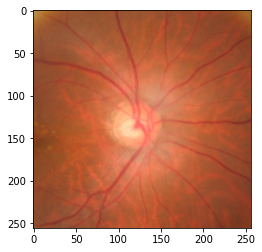

In [ ]:
from google.colab.patches import cv2_imshow
plt.imshow(image)


(1, 256, 256, 3)


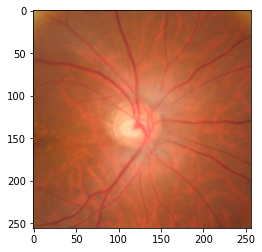

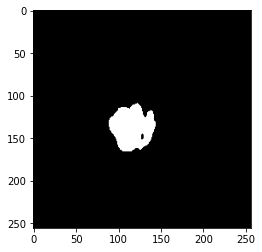

In [ ]:
batch_x = [image]
batch_x = np.array(batch_x).copy()
print(batch_x.shape)
batch_x = tf_to_th_encoding(batch_x)
batch_x = batch_x/255.0
batch_x = th_to_tf_encoding(batch_x)

plt.imshow(batch_x[0]); plt.show()
batch_x = np.array(batch_x)

batch_x = tf_to_th_encoding(batch_x)
pred = (model.predict(batch_x)[0, 0] > 0.5).astype(np.float64) #BINARY MASK HERE
plt.imshow(pred, cmap=plt.cm.Greys_r); plt.show()
#output image to jpg

# **REMOVING BLACK AREA:**

In [ ]:
rows, cols = (256, 256)
def findstarty(pred_mask):
  for i in range(rows):
    for j in range(cols):
      if pred_mask[i][j] == 1:
        return i

def findstartx(pred_mask):
  for j in range(cols):
    for i in range(rows):
      if pred_mask[i][j] == 1:
        return j

def findendy(pred_mask):
  start_y = findstarty(pred_mask)
  while True:
    for i in range(start_y, rows):
      no_of_white_pixels = 0
      for j in range(cols):
        if pred_mask[i][j] == 1:
          no_of_white_pixels += 1
      if no_of_white_pixels == 0:
        return i

def findendx(pred_mask):
  start_x = findstartx(pred_mask)
  while True:
    for j in range(start_x, rows):
      no_of_white_pixels = 0
      for i in range(rows):
        if pred_mask[i][j] == 1:
          no_of_white_pixels += 1
      if no_of_white_pixels == 0:
        return j

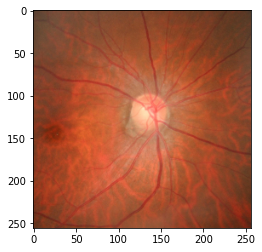

In [ ]:
image = cv2.imread(imgpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (WIDTH,HEIGHT))
plt.imshow(image)

# **CROPPING IMAGE**

In [ ]:
crop_img = image[findstarty(pred)-22:findendy(pred)+22, findstartx(pred)-22:findendx(pred)+22]

True

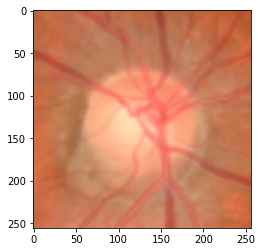

In [ ]:

crop_img = cv2.resize(crop_img, (WIDTH,HEIGHT))
plt.imshow(crop_img)
cv2.imwrite("/content/gdrive/MyDrive/output601.jpg",cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR))

 **GENERATING CROPPED IMAGES By U-Net: CROPPED v1.1**:



---
\


In [ ]:
#156 176 304 340 508 582 349 469, 483
import glob
filelist = glob.glob('/content/gdrive/MyDrive/ORIGA_cropped_v1.0_all/*.jpg')
filelist = sorted(filelist)
for fname in filelist:
  base = os.path.basename(fname)
  image = cv2.imread(fname)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (WIDTH,HEIGHT))
  batch_x = [image]
  batch_x = np.array(batch_x).copy()
  batch_x = tf_to_th_encoding(batch_x)
  batch_x = batch_x/255.0
  batch_x = th_to_tf_encoding(batch_x)
  if base not in ["288.jpg","349.jpg","483.jpg"]:
    batch_x = [skimage.exposure.equalize_adapthist(batch_x[i]) for i in range(len(batch_x))]
  else:
    print("do nothing")
  batch_x = np.array(batch_x)
  batch_x = tf_to_th_encoding(batch_x)
  if base in ["024.jpg","161.jpg","197.jpg"]:
    pred = (model.predict(batch_x)[0, 0] > 0.95).astype(np.float64)
  elif base in ["116.jpg", "134.jpg","149.jpg","152.jpg","190.jpg","225.jpg","251.jpg", "297.jpg", "299.jpg", "346.jpg", "404.jpg","430.jpg","469.jpg","599.jpg"]:
    pred = (model.predict(batch_x)[0, 0] > 0.7).astype(np.float64)
  elif base in ["084.jpg","315.jpg", "342.jpg","511.jpg","518.jpg","631.jpg"]:
    pred = (model.predict(batch_x)[0, 0] > 0.25).astype(np.float64)
  elif base in ["182.jpg", "218.jpg", "267.jpg"]:
    pred = (model.predict(batch_x)[0, 0] > 0.35).astype(np.float64)
  elif base in ["100.jpg"]:
    pred = (model.predict(batch_x)[0, 0] > 0.55).astype(np.float64)
  elif base in ["237.jpg", "582.jpg"]:
    pred = (model.predict(batch_x)[0, 0] > 0.9996).astype(np.float64)
  elif base in ["241.jpg"]:
    pred = (model.predict(batch_x)[0, 0] > 0.85).astype(np.float64)
  elif base in ["288.jpg", "301.jpg","483.jpg","527.jpg","535.jpg"]:
    pred = (model.predict(batch_x)[0, 0] > 0.3).astype(np.float64)
  elif base in ["301.jpg", "349.jpg"]:
    pred = (model.predict(batch_x)[0, 0] > 0.1).astype(np.float64)
  else:
    pred = (model.predict(batch_x)[0, 0] > 0.5).astype(np.float64)
  batch_x = th_to_tf_encoding(batch_x)
  crop_img = image[findstarty(pred)-10:findendy(pred)+10, findstartx(pred)-10:findendx(pred)+10]
  crop_img = cv2.resize(crop_img, (WIDTH,HEIGHT))
  pred[pred>0] = 255;
  crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
  cv2.imwrite('/content/gdrive/MyDrive/Masks_v1.2/'+base, pred)
  cv2.imwrite('/content/gdrive/MyDrive/Cropped_v1.2/'+base, crop_img)

do nothing
do nothing
do nothing


 **GENERATING CROPPED IMAGES By True Masks: CROPPED_true v1.0**:



---
\


In [ ]:
import scipy.io as sio

filelist = glob.glob('/content/gdrive/MyDrive/binarymask/*.mat')
filelist = sorted(filelist)
mat_contents = []
for fname in filelist:
  mat_content = sio.loadmat(fname)
  mask = mat_content['mask']
  mask[mask>0] = 1;
  img = cv2.resize(mask, (256,256))
  mat_contents.append(img)


filelist = glob.glob('/content/gdrive/MyDrive/Images/*.jpg')
filelist = sorted(filelist)
i = 0
for fname in filelist:
  base = os.path.basename(fname)
  image = cv2.imread(fname)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (WIDTH,HEIGHT))
  crop_img = image[findstarty(mat_contents[i])-10:findendy(mat_contents[i])+10, findstartx(mat_contents[i])-10:findendx(mat_contents[i])+10]
  crop_img = cv2.resize(crop_img, (WIDTH,HEIGHT))
  crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
  cv2.imwrite('/content/gdrive/MyDrive/Cropped_true_v1.0/'+base, crop_img)
  i+=1

 **GENERATING CROPPED IMAGES By True Masks: CROPPED v1.2**:



---
\

In [ ]:
import scipy.io as sio
import glob
from google.colab import drive
drive.mount('/content/gdrive')
import os

filelist = glob.glob('/content/gdrive/MyDrive/binarymask/*.mat')
filelist = sorted(filelist)
mat_contents = []
for fname in filelist:
  mat_content = sio.loadmat(fname)
  mask = mat_content['mask']
  mask[mask>0] = 1;
  img = cv2.resize(mask, (256,256))
  mat_contents.append(img)


filelist = glob.glob('/content/gdrive/MyDrive/Images/*.jpg')
filelist = sorted(filelist)
i = 0
for fname in filelist:
  base = os.path.basename(fname)
  image = cv2.imread(fname)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (256,256))
  crop_img = image[findstarty(mat_contents[i])-22:findendy(mat_contents[i])+22, findstartx(mat_contents[i])-22:findendx(mat_contents[i])+22]
  crop_img = cv2.resize(crop_img, (256,256))
  crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
  cv2.imwrite('/content/gdrive/MyDrive/Cropped_V1.4/'+base, crop_img)
  i+=1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


 **GENERATING CROPPED IMAGES By True Masks: CROPPED v1.2**:

In [ ]:
rows, cols = (2048, 3072)
def findstarty(pred_mask):
  for i in range(rows):
    for j in range(cols):
      if pred_mask[i][j] == 1:
        return i

def findstartx(pred_mask):
  for j in range(cols):
    for i in range(rows):
      if pred_mask[i][j] == 1:
        return j

def findendy(pred_mask):
  start_y = findstarty(pred_mask)
  while True:
    for i in range(start_y, rows):
      no_of_white_pixels = 0
      for j in range(cols):
        if pred_mask[i][j] == 1:
          no_of_white_pixels += 1
      if no_of_white_pixels == 0:
        return i

def findendx(pred_mask):
  start_x = findstartx(pred_mask)
  while True:
    for j in range(start_x, cols):
      no_of_white_pixels = 0
      for i in range(rows):
        if pred_mask[i][j] == 1:
          no_of_white_pixels += 1
      if no_of_white_pixels == 0:
        return j

import scipy.io as sio
import glob
from google.colab import drive
drive.mount('/content/gdrive')
import os
import cv2
filelist = glob.glob('/content/gdrive/MyDrive/binarymask/*.mat')
filelist = sorted(filelist)
mat_contents = []
for fname in filelist:
  mat_content = sio.loadmat(fname)
  mask = mat_content['mask']
  mask[mask>0] = 1;
  mat_contents.append(mask)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
len(mat_contents)
findendx(mat_contents[3])


2063

In [ ]:
filelist = glob.glob('/content/gdrive/MyDrive/Images/*.jpg')
filelist = sorted(filelist)
i = 0
for fname in filelist:
  base = os.path.basename(fname)
  image = cv2.imread(fname)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  crop_img = image[findstarty(mat_contents[i])-150:findendy(mat_contents[i])+150, findstartx(mat_contents[i])-150:findendx(mat_contents[i])+150]
  crop_img = cv2.resize(crop_img, (256,256))
  crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
  cv2.imwrite('/content/gdrive/MyDrive/Cropped_final/'+base, crop_img)
  i+=1

# **GENERATING CROPPED IMAGES For DrishtiGS:**

In [ ]:
rows, cols = (256, 256)
def findstarty(pred_mask):
  for i in range(rows):
    for j in range(cols):
      if pred_mask[i][j] == 1:
        return i

def findstartx(pred_mask):
  for j in range(cols):
    for i in range(rows):
      if pred_mask[i][j] == 1:
        return j

def findendy(pred_mask):
  start_y = findstarty(pred_mask)
  while True:
    for i in range(start_y, rows):
      no_of_white_pixels = 0
      for j in range(cols):
        if pred_mask[i][j] == 1:
          no_of_white_pixels += 1
      if no_of_white_pixels == 0:
        return i

def findendx(pred_mask):
  start_x = findstartx(pred_mask)
  while True:
    for j in range(start_x, rows):
      no_of_white_pixels = 0
      for i in range(rows):
        if pred_mask[i][j] == 1:
          no_of_white_pixels += 1
      if no_of_white_pixels == 0:
        return j
import glob
filelist = glob.glob('/content/gdrive/My Drive/Drighti-GS1/*.png')
filelist = sorted(filelist)
for fname in filelist:
  base = os.path.basename(fname)
  image = cv2.imread(fname)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (256,256))
  batch_x = [image]
  batch_x = np.array(batch_x).copy()
  batch_x = tf_to_th_encoding(batch_x)
  batch_x = batch_x/255.0
  batch_x = th_to_tf_encoding(batch_x)
  batch_x = [skimage.exposure.equalize_adapthist(batch_x[i]) for i in range(len(batch_x))]
  batch_x = np.array(batch_x)
  batch_x = tf_to_th_encoding(batch_x)
  pred = (model.predict(batch_x)[0, 0] > 0.5).astype(np.float64)
  batch_x = th_to_tf_encoding(batch_x)
  image = cv2.imread(fname)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  crop_img = image[findstarty(pred)*7-80:findendy(pred)*7+80, findstartx(pred)*8-80:findendx(pred)*8+80]
  crop_img = cv2.resize(crop_img, (256,256))
  pred[pred>0] = 255;
  crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
  cv2.imwrite('/content/gdrive/MyDrive/Drighti-GS1/Cropped_UNET/'+base, crop_img)